# Modeling Real Estate Predictions
The purpose of this notebook is to injest a pre-processed data file for NJ real estate and use it to create, train and evaluate a model for predicting property values.

# 1 Train Test Split
First we need to split our data into training, validation and test data sets.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

current_directory = os.getcwd()
print(current_directory)

/Users/jleelong/workspace/sample-similarity-search


In [2]:
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

file_path = 'data/sample/processed.pkl'
if os.path.exists(file_path):
    df = pd.read_pickle(file_path).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    raise ValueError(f"{file_path} does not exist")
print(df.shape)
df

(4406, 40)


,lat,lng,No_Of_Dwellings,Corporate_Owned,Absentee,updated_at,Sq_Ft,Building_Class,Yr_Built,TaxRate,TaxRatio,RateYear,Recorded_Taxes,Year_1,Land_Assmnt_1,Building_Assmnt_1,Total_Assmnt_1,Sale_Price,Sale_Month,Sale_Year,Bergen,Burlignton,Camden,Cape May,Cumberland,Essex,Gloucester,Hudson,Hunterdon,Mercer,Middlesex,Monmouth,Morris,Ocean,Passaic,Salem,Somerset,Sussex,Union,Warren
0,40.660078,-74.232038,1,False,0,1736704394000,1803,17,1911,1.924,7.02,2024,11943.40,2025,167500.0,166400.0,333900,290000.0,5,2019,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,40.668140,-74.247636,1,False,0,1736704394000,1917,17,1939,1.924,7.02,2024,13954.92,2025,270500.0,316700.0,587200,418000.0,6,2019,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,40.663306,-74.238224,1,False,0,1736704394000,887,19,2007,1.924,7.02,2024,5657.40,2025,93800.0,167000.0,260800,145000.0,7,2020,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,40.679890,-74.210479,2,False,0,1736704394000,2544,17,1915,1.924,7.02,2024,11440.52,2025,203000.0,355700.0,558700,620000.0,8,2023,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,40.679137,-74.214241,1,False,1,1736704394000,1056,19,1988,1.924,7.02,2024,7071.75,2025,74700.0,208300.0,283000,65000.0,10,1995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4401,40.658638,-74.217361,1,False,0,1736704394000,1147,17,1900,1.924,7.02,2024,6065.99,2025,157000.0,131900.0,288900,85000.0,3,1992,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4402,40.681248,-74.215856,1,False,0,1736704394000,3644,17,1910,1.924,7.02,2024,14960.68,2025,260400.0,343800.0,604200,575000.0,1,2022,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4403,40.653699,-74.226884,4,False,1,1736704394000,3120,17,1928,1.924,7.02,2024,11817.68,2025,218400.0,453800.0,672200,160000.0,5,1996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4404,40.648365,-74.213538,2,False,0,1736704394000,3028,17,2007,1.924,7.02,2024,18575.13,2025,206800.0,519100.0,725900,735000.0,12,2021,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [3]:
X = df.drop('Sale_Price', axis=1).values
y = df['Sale_Price'].values

# perform a 60% / 20% / 20% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Train Split: {round(len(X_train)/len(df)*100)}% with {len(X_train)} rows")
print(f"Validation : {round(len(X_val)/len(df)*100)}% with {len(X_val)} rows")
print(f"Test Split : {round(len(X_test)/len(df)*100)}% with {len(X_test)} rows")

Train Split: 60% with 2643 rows
Validation : 20% with 881 rows
Test Split : 20% with 882 rows


# 2 Normalization
Now we need to scale the data for our model, but we'll reuse the scaler across runs, since our files will have some variation and we want the data normization to be consistent across files.

In [4]:
from sklearn.preprocessing import MinMaxScaler
import joblib

file_path = 'data/sample/scaler.save'
if os.path.exists(file_path):
    scaler = joblib.load(file_path)
    X_train = scaler.transform(X_train)
else:
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    joblib.dump(scaler, file_path)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 3 Create and Fit the Model
Next we can build a model from our training and validation data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
X_train.shape

(589416, 40)

In [6]:
from tensorflow.keras.models import load_model

file_path = 'data/sample/model.h5'
if os.path.exists(file_path):
    model = load_model(file_path)
else:
    model = Sequential()
    model.add(Dense(40, activation='relu')) # Inputs
    
    model.add(Dense(640, activation='relu')) # First hidden layer
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    
    model.add(Dense(640, activation='relu')) # Second hidden layer
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    
    model.add(Dense(640, activation='relu')) # Third hidden layer
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    
    model.add(Dense(640, activation='relu')) # Forth hidden layer
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    
    model.add(Dense(1, activation='relu')) # Output layer (regression)
    model.compile(optimizer='adam', loss='mse')

In [7]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
model.fit(x=X_train, y=y_train, epochs=1000, batch_size=32,
          validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/1000


2025-03-17 12:52:22.099236: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18420/18420 [==============================] - 54s 3ms/step - loss: 1803773280256.0000 - val_loss: 2362627850240.0000
Epoch 2/1000
18420/18420 [==============================] - 54s 3ms/step - loss: 1798385434624.0000 - val_loss: 2358953902080.0000
Epoch 3/1000
18420/18420 [==============================] - 54s 3ms/step - loss: 1797069996032.0000 - val_loss: 2357163720704.0000
Epoch 4/1000
18420/18420 [==============================] - 53s 3ms/step - loss: 1796065722368.0000 - val_loss: 2356254343168.0000
Epoch 5/1000
18420/18420 [==============================] - 53s 3ms/step - loss: 1794702966784.0000 - val_loss: 2358219898880.0000
Epoch 6/1000
18420/18420 [==============================] - 54s 3ms/step - loss: 1794544762880.0000 - val_loss: 2356773912576.0000
Epoch 7/1000
18420/18420 [==============================] - 55s 3ms/step - loss: 1794707161088.0000 - val_loss: 2360448909312.0000
Epoch 8/1000
18420/18420 [==============================] - 56s 3ms/step - loss: 1794042232832.0

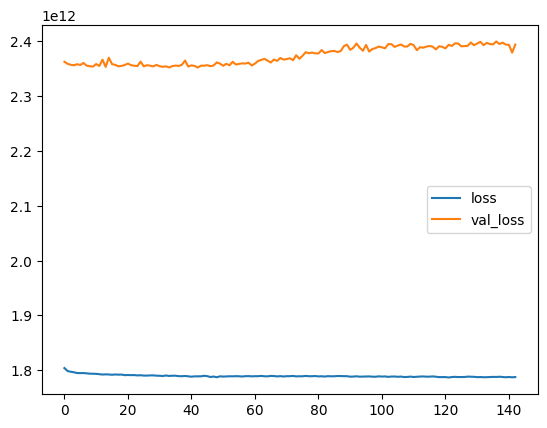

In [8]:
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.show()

In [9]:
model.save('data/sample/model.h5')

# 4 Evaluate the Model
And then we'll test the model to verify it's performance

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

print(X_test.shape)
X_test

(196472, 40)


array([[0.82420362, 0.93927061, 0.01190476, ..., 0.        , 0.        ,
        0.        ],
       [0.53853029, 0.78565194, 0.01190476, ..., 0.        , 0.        ,
        0.        ],
       [0.41650243, 0.28318124, 0.01190476, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.61011088, 0.81855985, 0.01190476, ..., 0.        , 0.        ,
        0.        ],
       [0.88312526, 0.87079562, 0.01190476, ..., 0.        , 0.        ,
        0.        ],
       [0.88495963, 0.87433645, 0.01190476, ..., 0.        , 0.        ,
        0.        ]])

In [11]:
predictions = model.predict(X_test)
mean_absolute_error(y_test, predictions)

6140/6140 [==============================] - 4s 657us/step


166820.09649589547

In [12]:
np.sqrt(mean_absolute_error(y_test, predictions))

408.4361596331739

In [13]:
explained_variance_score(y_test, predictions)

0.3685374942979017

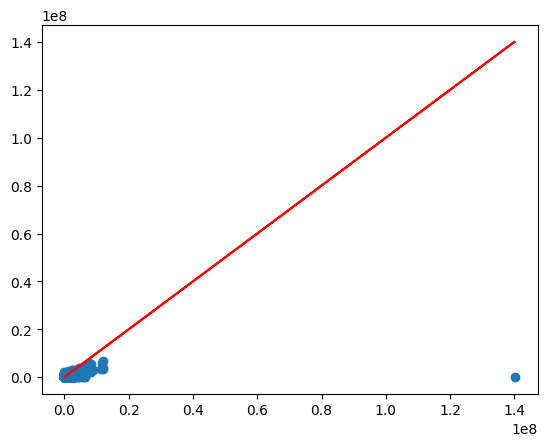

In [14]:
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test, 'r')
plt.show()

In [15]:
errors = y_test.reshape(X_test.shape[0], 1) - predictions

In [1]:
sns.histplot(errors, kde=True, stat='density', alpha=0.4, edgecolor=(1,1,1,0.4))
plt.xlim(-300000, 300000)
plt.show()

NameError: name 'sns' is not defined